This notebook does not prep the data. Train/val/test split is very unbalanced.

## Task: Prior to starting, transfer function to a python file so they can be imported and take up less real estate.

In [1]:
#Imports
import numpy as np
import pandas as pd
import os
import shutil
import glob
import itertools
import random
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner
from keras_tuner import RandomSearch, GridSearch
from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import Image

C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorflow\python\framework

C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensor

In [2]:
#Preferences
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [3]:
#Path variables
train_path = "data/train/"
val_path = "data/val/"
test_path = "data/test/"

In [4]:
path_list = [train_path, val_path, test_path]

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = datagen.flow_from_directory(directory=train_path,
                                              target_size=(256,256),
                                              batch_size=16,
                                              color_mode="rgb",
                                              classes=["NORMAL", "viral_pneumonia", "bacterial_pneumonia"],
                                              save_format="jpeg")

Found 4332 images belonging to 3 classes.


In [7]:
val_generator = datagen.flow_from_directory(directory=val_path,
                                            target_size=(256,256),
                                            batch_size=16,
                                            color_mode="rgb",
                                            classes=["NORMAL", "viral_pneumonia", "bacterial_pneumonia"],
                                            save_format="jpeg")

Found 900 images belonging to 3 classes.


In [8]:
test_generator = datagen.flow_from_directory(directory=test_path,
                                             target_size=(256,256),
                                             batch_size=16,
                                             color_mode="rgb",
                                             classes=["NORMAL", "viral_pneumonia", "bacterial_pneumonia"],
                                             save_format="jpeg",
                                             shuffle=False)

Found 624 images belonging to 3 classes.


### Transfer learning

In [9]:
earlystop = EarlyStopping(monitor="val_loss", patience = 4)

In [15]:
list_of_models = ["DenseNet121", "DenseNet169", "DenseNet201", "InceptionResNetV2", "InceptionV3", "MobileNet", "MobileNetV2", "ResNet50", "VGG16", "VGG19", "Xception"]

In [16]:
#inception_resnet_v2 and inception_v3 threw an error so I'm trying the rest
shorter_list = ["VGG16", "VGG19", "Xception"]

In [12]:
train_generator.reset()
val_generator.reset()
test_generator.reset()

In [13]:
model_metrics = []

In [17]:
for app_model in list_of_models:
    base_model = getattr(keras.applications, app_model)(
    weights="imagenet",
    input_shape=(256,256,3),
    include_top=False)
    
    base_model.trainable = False
    
    inputs = keras.Input(shape=(256,256,3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(3)(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[keras.metrics.CategoricalAccuracy()])

    history = model.fit(train_generator, epochs=10, validation_data=val_generator)
    
    model_accuracy = history.history["categorical_accuracy"]
    model_val_accuracy = history.history["val_categorical_accuracy"]
    predictions = model.predict(x=test_generator, verbose=0)
    temp_dict = {"model":app_model,
                 "train_acc":model_accuracy,
                 "val_acc":model_val_accuracy,
                 "test_preds": predictions}
    model_metrics.append(temp_dict)
    
    train_generator.reset()
    val_generator.reset()
    test_generator.reset()

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/10
271/271 [==============================] - 1983s 7s/step - loss: 0.8996 - categorical_accuracy: 0.5826 - val_loss: 0.9117 - val_categorical_accuracy: 0.5622
Epoch 2/10
271/271 [==============================] - 1986s 7s/step - loss: 0.7397 - categorical_accuracy: 0.6844 - val_loss: 0.7577 - val_categorical_accuracy: 0.6789
Epoch 3/10
271/271 [==============================] - 1980s 7s/step - loss: 0.6781 - categorical_accuracy: 0.7080 - val_loss: 0.7206 - val_categorical_accuracy: 0.6533
Epoch 4/10
271/271 [==============================] - 1977s 7s/step - loss: 0.6407 - categorical_accuracy: 0.7248 - val_loss: 0.6751 - val_categorical_accuracy: 0.7256
Epoch 5/10
271/271 [==============================] - 1974s 7s/step - loss: 0.6170 - categorical_accuracy: 0.7368 - val_loss: 0.6784 - val_categorical_accuracy: 0.7033
Epoch 6/10
271/271 [==============================] - 1975s 7s/step - loss: 0.5970 - categorica

In [18]:
def plot_model_metrics(model_metrics, test_generator):
    plt.figure(figsize=(15, 8))
    
    for data in model_metrics:
        plt.plot(data["train_acc"], label=f'{data["model"]} Train Acc')
        plt.plot(data["val_acc"], label=f'{data["model"]} Val Acc')
        
        # Compute test accuracy using the predictions
        y_pred = np.argmax(data["test_preds"], axis=1)
        y_true = test_generator.classes
        test_acc = accuracy_score(y_true, y_pred)
        print(f"{data['model']} Test Accuracy: {test_acc * 100:.2f}%")
        
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

DenseNet121 Test Accuracy: 77.56%


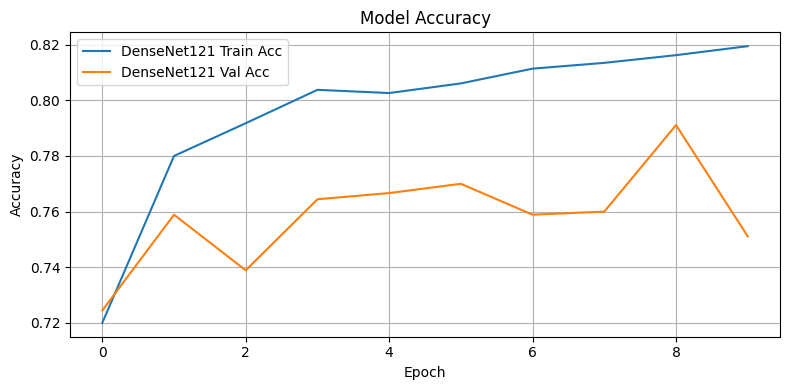

DenseNet169 Test Accuracy: 74.68%


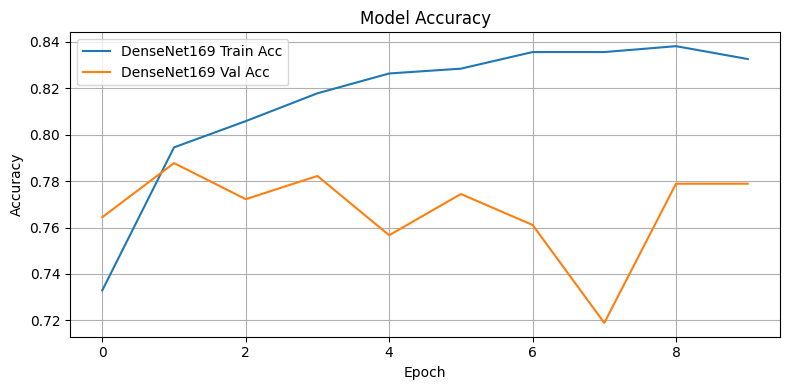

DenseNet201 Test Accuracy: 73.72%


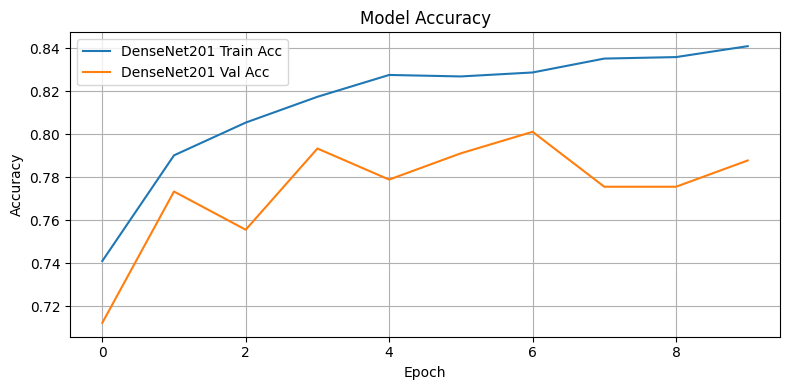

InceptionResNetV2 Test Accuracy: 66.03%


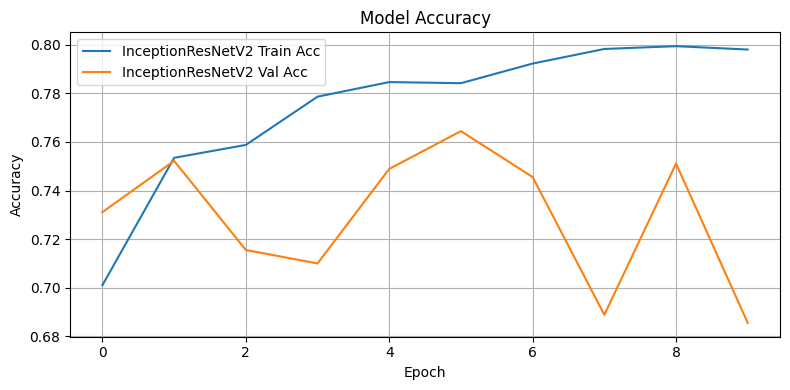

InceptionV3 Test Accuracy: 62.50%


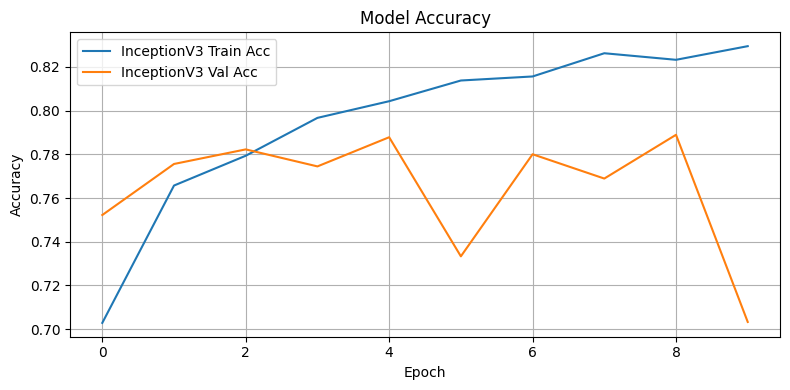

MobileNet Test Accuracy: 79.97%


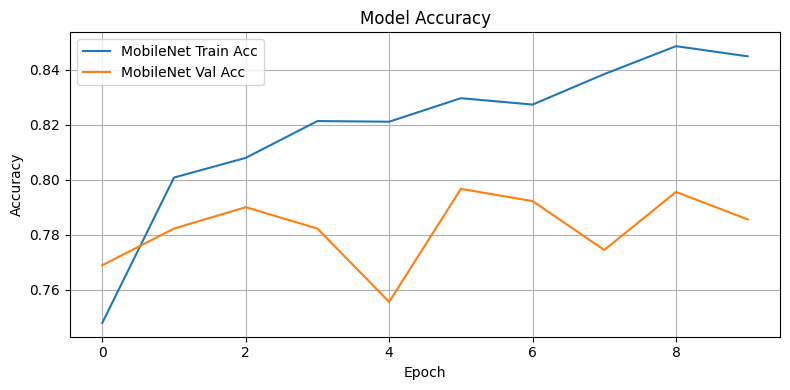

MobileNetV2 Test Accuracy: 68.59%


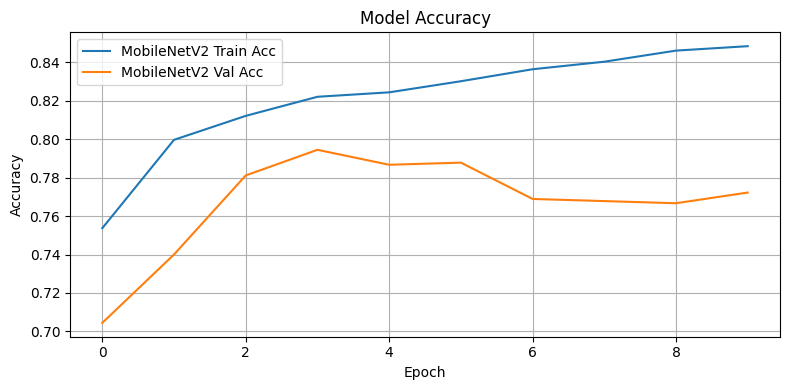

ResNet50 Test Accuracy: 51.92%


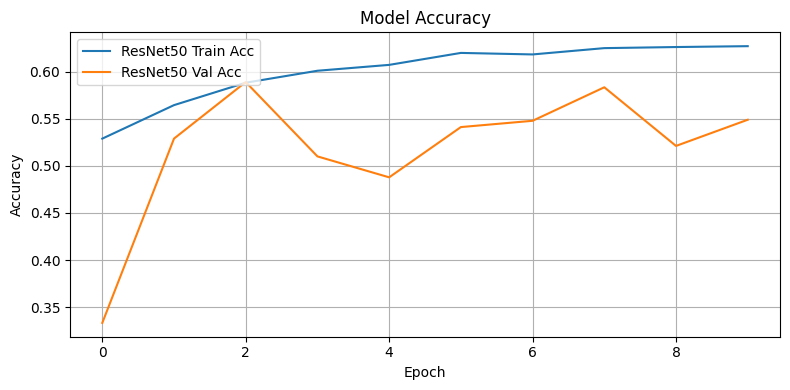

VGG16 Test Accuracy: 76.76%


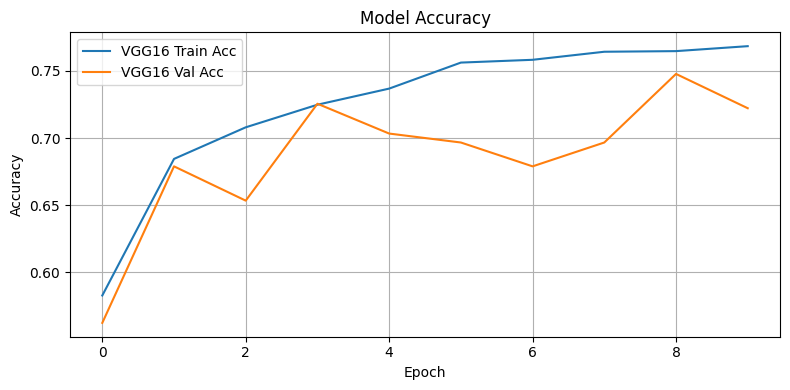

VGG19 Test Accuracy: 69.55%


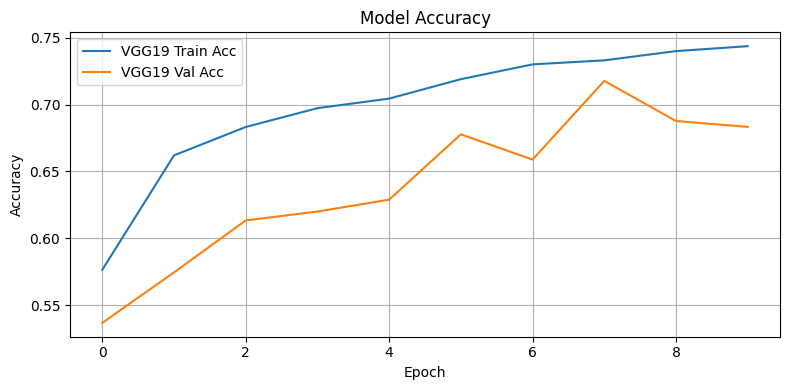

Xception Test Accuracy: 74.04%


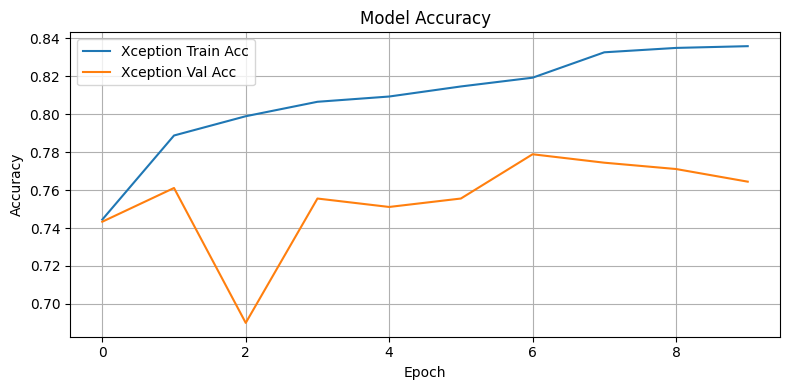

In [23]:
for data in model_metrics:
    plt.figure(figsize=(8, 4))
    plt.plot(data["train_acc"], label=f'{data["model"]} Train Acc')
    plt.plot(data["val_acc"], label=f'{data["model"]} Val Acc')

    # Compute test accuracy using the predictions
    y_pred = np.argmax(data["test_preds"], axis=1)
    y_true = test_generator.classes
    test_acc = accuracy_score(y_true, y_pred)
    print(f"{data['model']} Test Accuracy: {test_acc * 100:.2f}%")
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

DenseNet121 Test Accuracy: 77.56%
DenseNet169 Test Accuracy: 74.68%
DenseNet201 Test Accuracy: 73.72%
InceptionResNetV2 Test Accuracy: 66.03%
InceptionV3 Test Accuracy: 62.50%
MobileNet Test Accuracy: 79.97%
MobileNetV2 Test Accuracy: 68.59%
ResNet50 Test Accuracy: 51.92%
VGG16 Test Accuracy: 76.76%
VGG19 Test Accuracy: 69.55%
Xception Test Accuracy: 74.04%


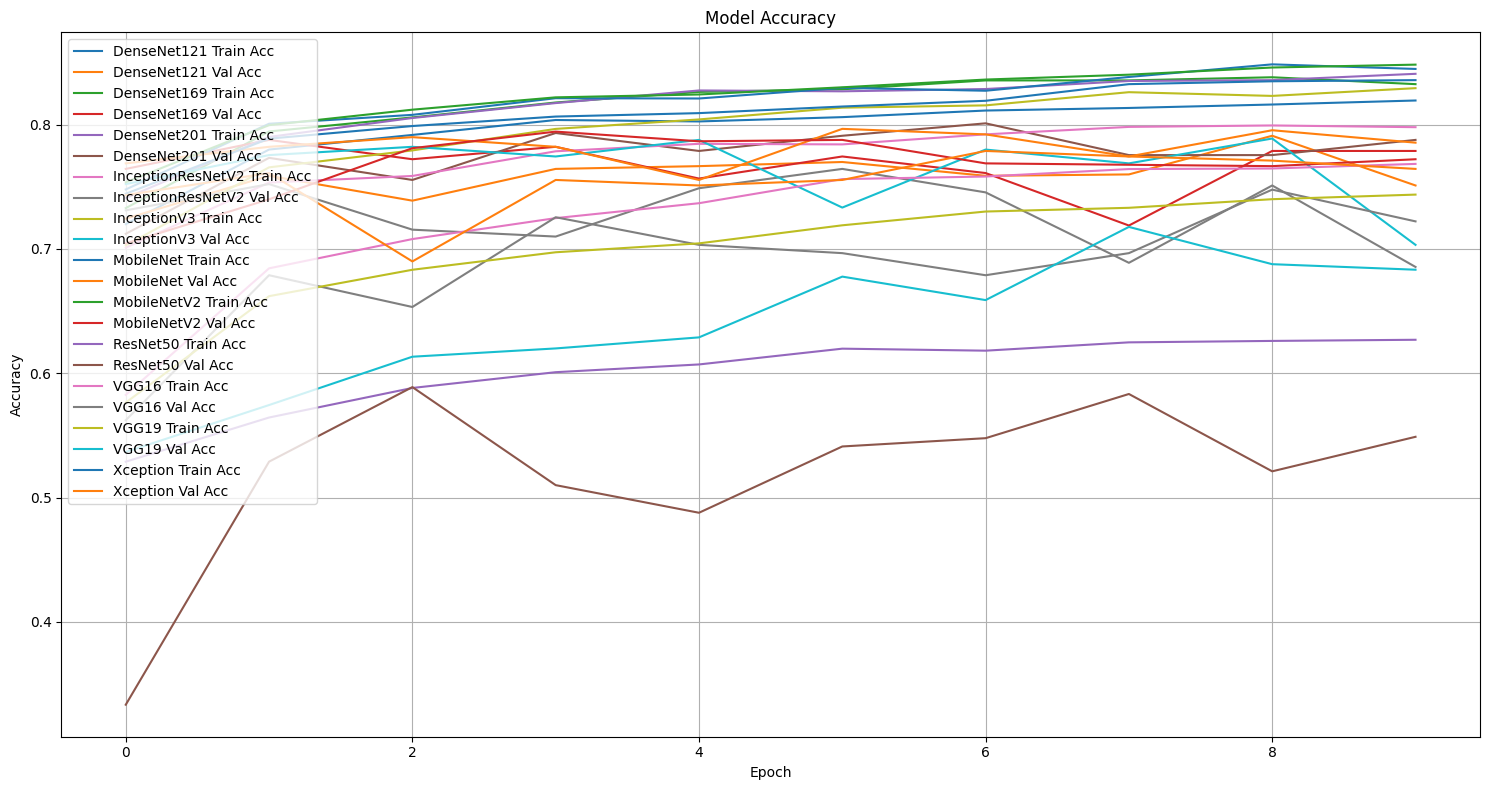

In [20]:
plot_model_metrics(model_metrics, test_generator)